In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import h5py

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'met_met', 'met_phi'] 
# Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
Y_keys = ['th_pt', 'th_eta', 'th_m']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  500000 

In [2]:
import scale_variables

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'boxcox', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'meanmax', 'm':'boxcox', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(X_keys, X_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 1.4495071809506044e-12


In [3]:
# Create X and test array
split = int(np.floor(0.9*crop0))
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(X_total)
    np.random.set_state(rng_state)
    np.random.shuffle(Y_total)

trainX, testX = X_total[0:split, :], X_total[split:,:]
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

# sin = trainY[:, Y_names.index('th_phi-sin')]
# tr_weights = 1+10*sin**2
# del sin 

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(450000, 41) (450000, 3)
(50000, 41) (50000, 3)


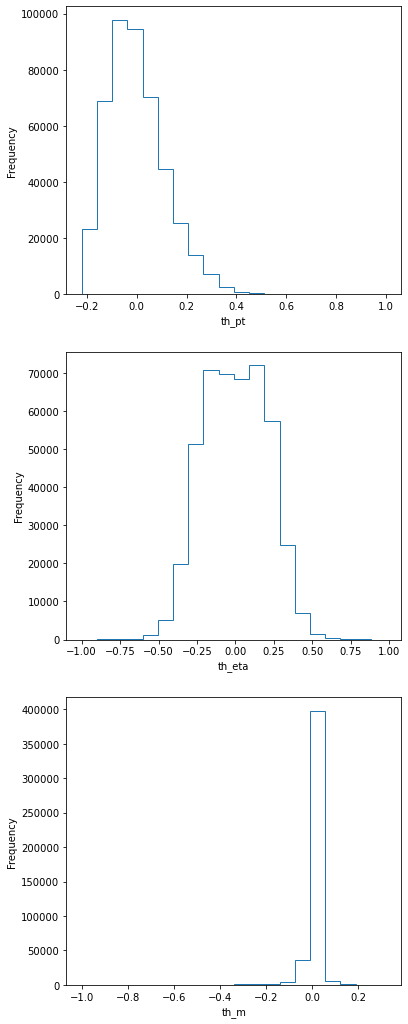

In [4]:
# Histograms of Y variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        plt.hist(trainY[:,i], 20, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables 
show = False

if show:
    plt.figure(figsize=(6,6*trainX.shape[1]))
    for i in range(0, trainX.shape[1]):
        plt.subplot(trainX.shape[1], 1, i+1)
        plt.hist(trainX[:,i], 20, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [6]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu',
                     input_shape=[len(X_names)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128,  activation='relu'),
        layers.Dense(len(Y_names),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      X_shape=[len(X_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [7]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               21504     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 251,907
Trainable params: 251,907
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Fit model

Epochs= 1

history = model.fit(trainX, trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Train on 360000 samples, validate on 90000 samples
360000/360000 [==============================] - 3s 9us/sample - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0052 - val_mse: 0.0052


Text(0.5, 1.0, 'MSE loss')

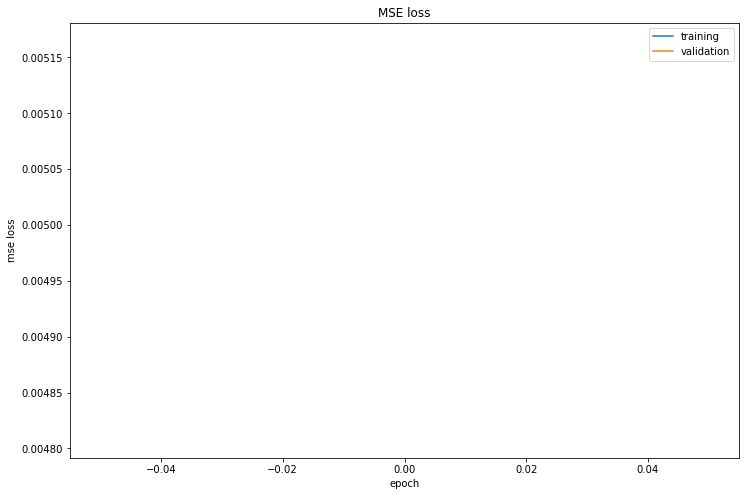

In [10]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [11]:
class Analysis:
    def __init__(self):
        self.crop = 100
        self.fsize = 6
        self.histogram_bins = 40
        
    def wrap_phi(self, var):
        var = var%(2*np.pi)
        var = var - 2*np.pi*(var > np.pi)
        return var
        
    def predictions_vs_sample(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2, self.fsize*len(names)))
        for i in range(0, len(names)):
            compare_small = compare[:self.crop,i]
            true_small = true[:self.crop,i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            plt.subplot(len(names), 1, i+1)
            plt.plot(range(0,self.crop), compare_small, 'bo', markersize=3, label = 'Predictions')
            plt.plot(range(0,self.crop), true_small, 'ro', markersize=3, label = 'True Value')
            ym, yM = plt.ylim()
            for x in range(self.crop):
                plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                            min(compare_small[x], true_small[x]), 
                            ymax= max(compare_small[x], true_small[x]))
            plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=self.crop+20, alpha=0.5)
            MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
            plt.xlabel('Sample')
            plt.xlim(0, self.crop)
            plt.ylabel(names[i])
            plt.title(names[i] + " MSE: " + str(MSE))
            plt.legend()
    
    def display_errors(self, compare, true, names, wrap_phi):
        MSE = 1/compare.size*np.sum((compare- true)**2)
        print("total MSE: " + str(MSE))
        print(" ")
        for i in range(len(names)):
            diff = compare[:,i] -true[:,i]
            if wrap_phi and "phi" in names[i]:
                diff = self.wrap_phi(diff)
            MSE = 1/compare[:,i].size*np.sum((diff)**2)
            print("{0} MSE : ".format(names[i]), '%.10f'%MSE)
    
    def difference_histogram(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            diff = true[:,i] - compare[:,i]
            if wrap_phi and "phi" in names[i]:
                diff = self.wrap_phi(diff)
            hist0, bin_edges = np.histogram(true[:, i], bins=self.histogram_bins)
            plt.hist(diff, self.histogram_bins, histtype='step', color='purple', label='true - predicted', density=True)
            plt.xlabel("Difference (Mean: {0}, Std: {1})".format(np.mean(diff), np.std(diff)))
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
            
    def variable_histogram(self, compare, true, names, wrap_phi): 
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            compare_small = compare[:, i]
            true_small = true[:, i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            # hist, edges = np.histogram(true_small, self.histogram_bins)
            plt.hist(true_small, self.histogram_bins, histtype='step', color='b', label='true values', density=True)
            plt.hist(compare_small, self.histogram_bins, histtype='step', color='r', label='predictions', density=True)
            plt.xlabel(names[i])
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
    
    def difference_vs_variable(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], true[:, i]-compare[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
            plt.xlabel('True ' + names[i])
            plt.legend()
            plt.ylabel('Difference')
    
    def predicted_vs_true(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], compare[:, i], 'o', color='g', markersize=2)
            line = np.linspace(np.min(true[:, i]), np.max(true[:, i]), 100)
            plt.plot(line, line, color='b')
            plt.xlabel('True')
            plt.title(names[i])
            plt.ylabel('Predicted')

In [12]:

display = Analysis()

predictions_unscaled = model.predict([testX])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX,testX,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

# Training scale plots 

In [13]:
display.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.005160318864873498
 
th_pt MSE :  0.0041597743
th_eta MSE :  0.0096758326
th_m MSE :  0.0016453498


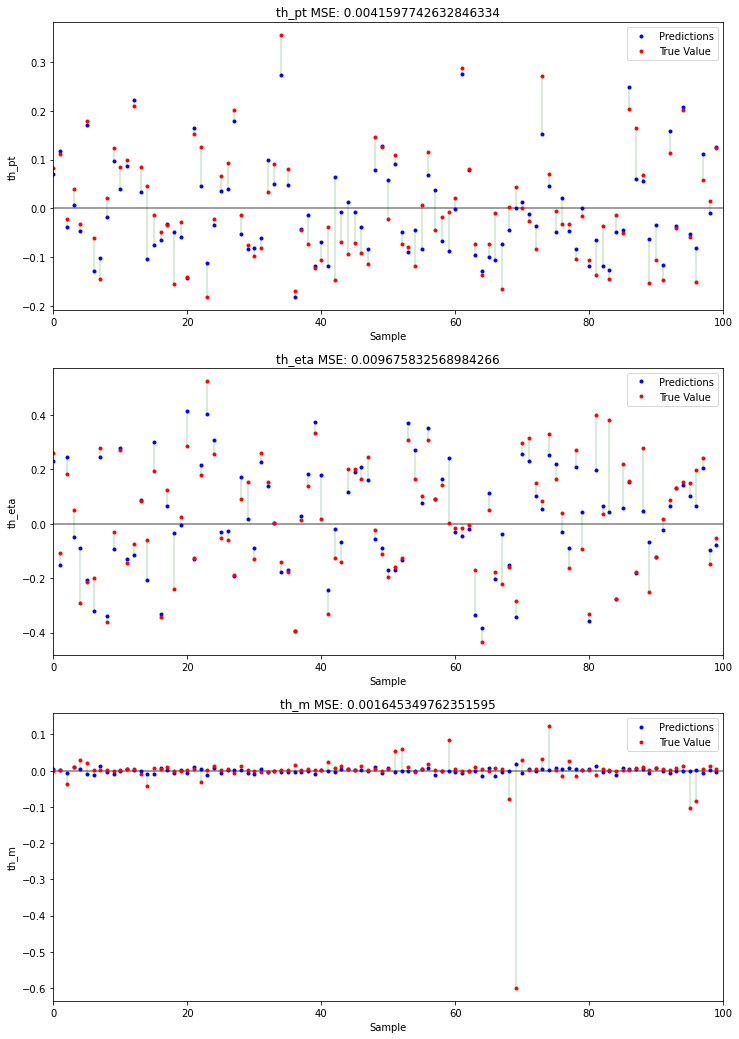

In [14]:
display.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

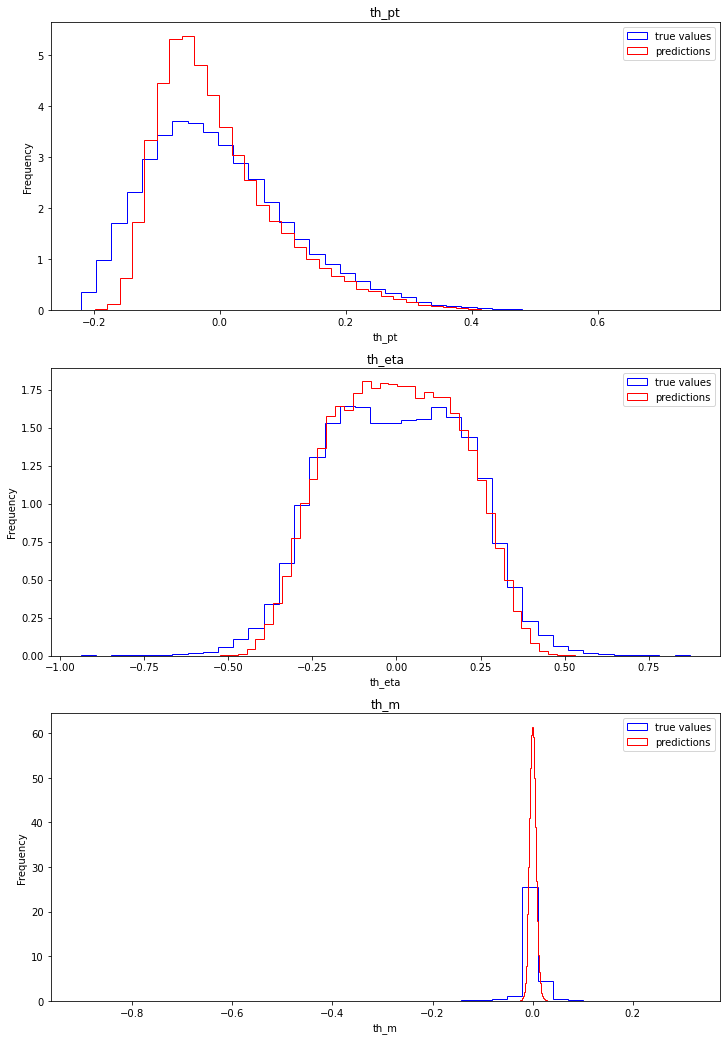

In [15]:
display.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False)

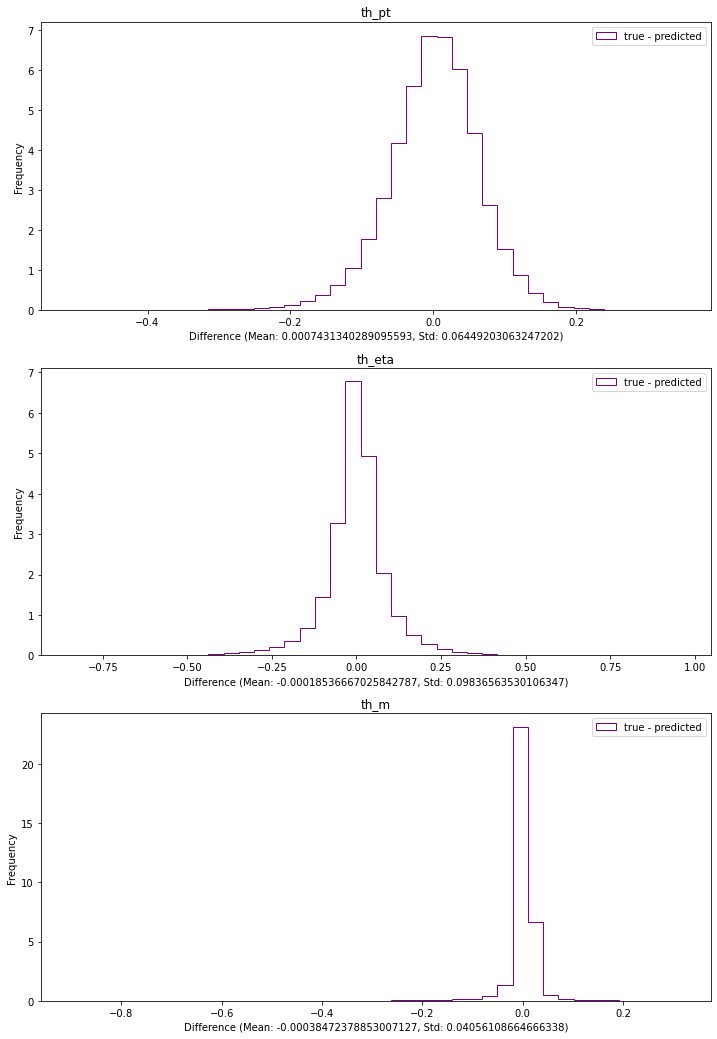

In [16]:
display.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False)

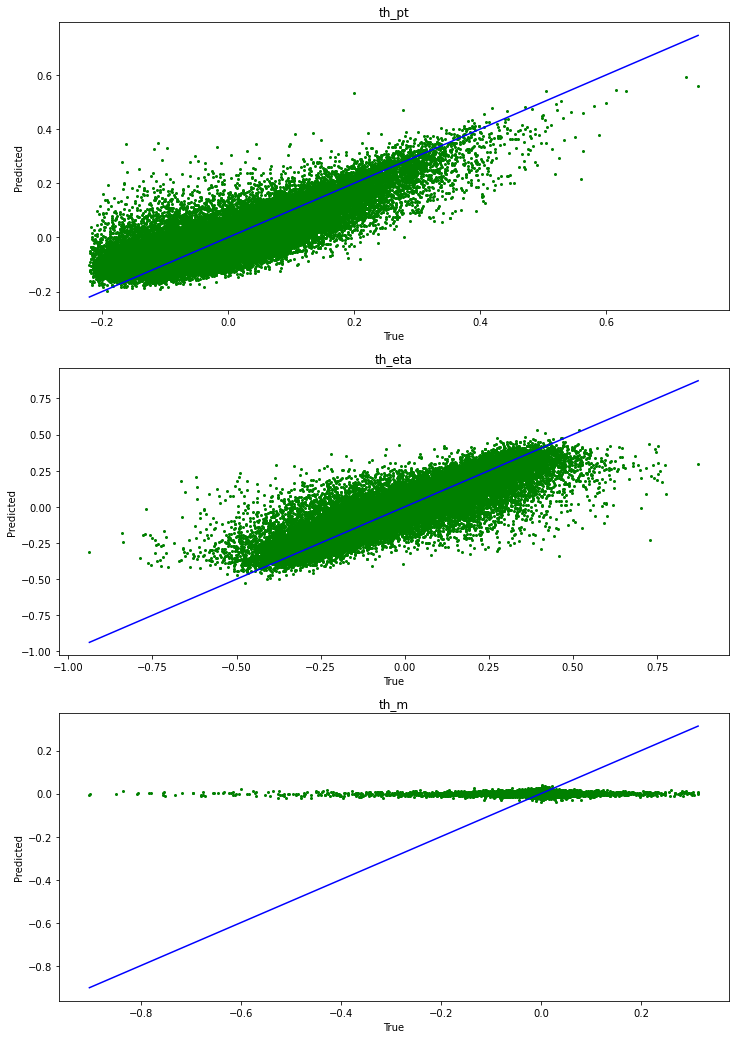

In [17]:
display.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [18]:
display.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 605.2752366297381
 
th_pt MSE :  1781.4739556918
th_eta MSE :  0.5739035875
th_m MSE :  33.7778506099


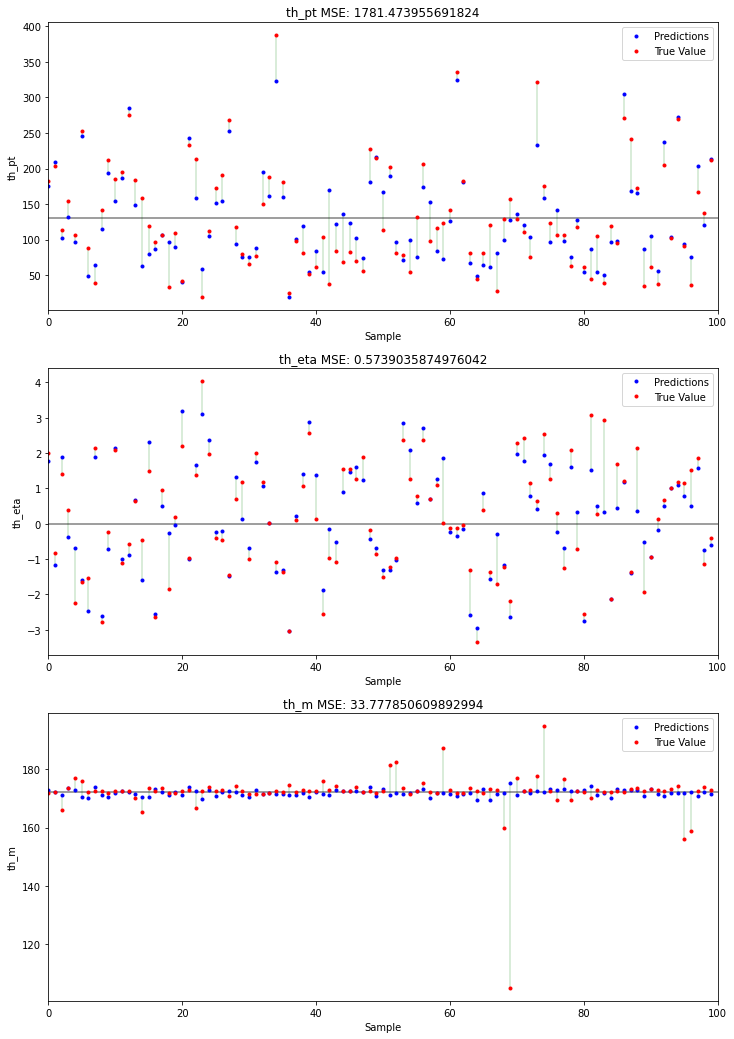

In [19]:
display.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

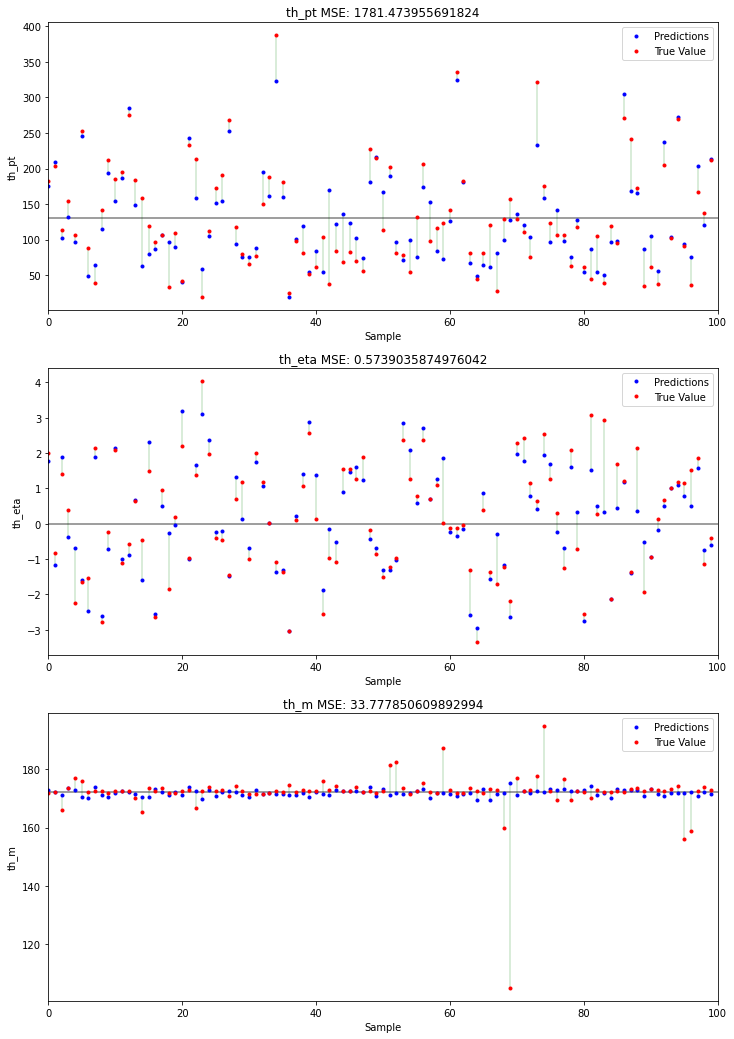

In [20]:
display.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

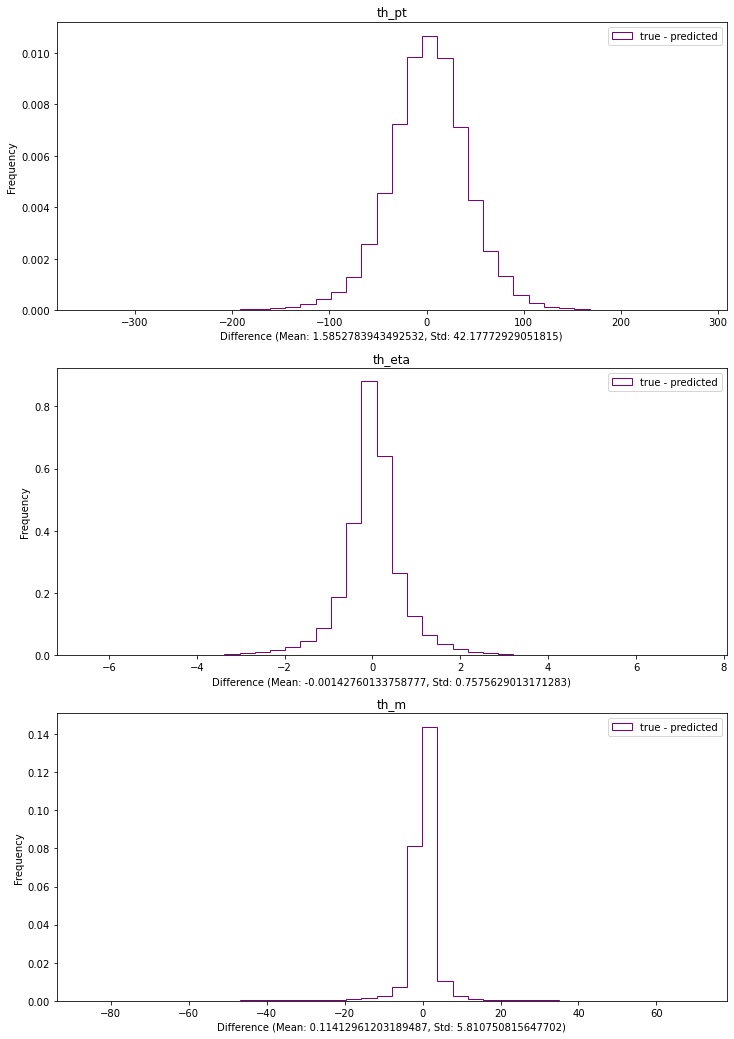

In [21]:
display.difference_histogram(predictions_origscale, true_origscale, Y_keys, True)

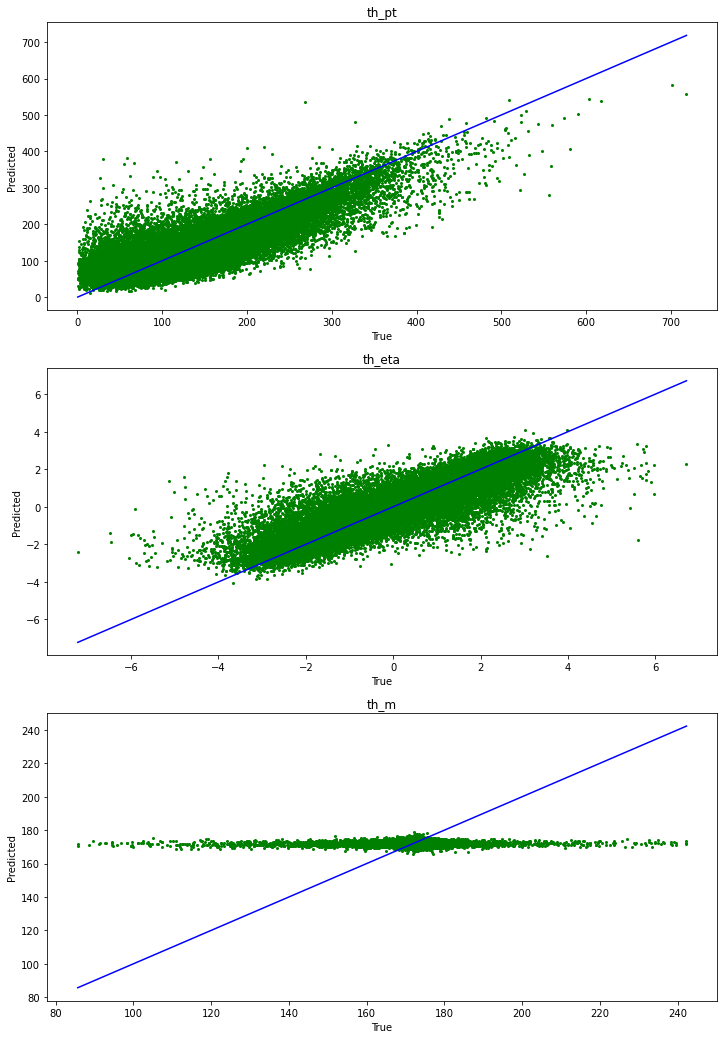

In [22]:
display.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)